In [ ]:
!pip install transformers
!pip install datasets

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import re
import glob
import random
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling, TrainerCallback
from datasets import load_dataset, Dataset
from transformers import TrainerCallback
from transformers import GenerationConfig

In [3]:
# Set environment variable to prevent memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Enable benchmark mode for cuDNN to improve performance
torch.backends.cudnn.benchmark = True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the already cleaned data from the .txt file
file_path = '/content/drive/MyDrive/finetuning data/Hausa General Corpus.txt'  # Adjust the file path accordingly
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

# Split the text into sentences
sentences = re.split(r'(?<=[.!?]) +', text_data)  # Split by sentence-ending punctuation

# Create a DataFrame and split the dataset
df = pd.DataFrame(sentences, columns=['text'])
train_texts, temp_texts = train_test_split(df['text'], test_size=0.30, random_state=42)
val_texts, test_texts = train_test_split(temp_texts, test_size=0.6667, random_state=42)

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_dict({"text": train_texts})
val_dataset = Dataset.from_dict({"text": val_texts})
test_dataset = Dataset.from_dict({"text": test_texts})

# Check the sizes of each split
print("Training examples:", len(train_dataset))
print("Validation examples:", len(val_dataset))
print("Test examples:", len(test_dataset))

Training examples: 30886
Validation examples: 4412
Test examples: 8826


In [6]:
print((train_dataset[1]))

{'text': 'Sai ta ce, “‘Af, ashe ma fikafikai guda biyu sun kone tun dazun, bari in cinye na dayar kuma don su zo daidai, kada mai gida ya gane.’’ Sai ta kama fikafikai ta fiffizge ta lakwame.'}


In [7]:
model_name = "castorini/afriberta_small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

# Set max length for tokenization
tokenizer.model_max_length = 512

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/333M [00:00<?, ?B/s]

In [8]:
# Enable gradient checkpointing to reduce memory usage
model.gradient_checkpointing_enable()

In [9]:
# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

# Use the DataCollatorForLanguageModeling for dynamic padding and MLM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

Map:   0%|          | 0/30886 [00:00<?, ? examples/s]

Map:   0%|          | 0/4412 [00:00<?, ? examples/s]

In [10]:
# Define a custom callback to save the model at each epoch with a unique name

# Callback to save models at each epoch
class SaveModelCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, model=None, tokenizer=None, **kwargs):
        output_dir = f"/content/drive/MyDrive/finetuned_afriberta_mlm_epoch_{int(state.epoch)}"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # Save the model
        model.save_pretrained(output_dir)
        if tokenizer:  # Ensure tokenizer is not None
            tokenizer.save_pretrained(output_dir)
        print(f"Model saved at {output_dir}")

# Set up training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/mlm_results",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,  # Adjust based on your GPU memory
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=5,  # keep all 5 saved models
    save_strategy="epoch",    # Save at the end of each epoch
    load_best_model_at_end=False,  # We want to manually load each epoch's model later
    logging_dir='./logs',
    report_to="tensorboard"
)

# Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    callbacks=[SaveModelCallback()]  # Add the custom callback to save models after each epoch
)


In [11]:
# Start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Epoch,Training Loss,Validation Loss
1,3.229100,3.035186
2,3.092400,2.957038
3,3.033300,2.907426
4,2.953600,2.887058


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


Model saved at /content/drive/MyDrive/finetuned_afriberta_mlm_epoch_1


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_leng

Model saved at /content/drive/MyDrive/finetuned_afriberta_mlm_epoch_2


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_leng

Model saved at /content/drive/MyDrive/finetuned_afriberta_mlm_epoch_3


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_leng

Model saved at /content/drive/MyDrive/finetuned_afriberta_mlm_epoch_4


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_leng

Model saved at /content/drive/MyDrive/finetuned_afriberta_mlm_epoch_5


Epoch,Training Loss,Validation Loss
1,3.229100,3.035186
2,3.092400,2.957038
3,3.033300,2.907426
4,2.953600,2.887058
5,2.922900,2.890522


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


TrainOutput(global_step=19305, training_loss=3.0844728996950677, metrics={'train_runtime': 14988.5445, 'train_samples_per_second': 10.303, 'train_steps_per_second': 1.288, 'total_flos': 1.376505093101568e+16, 'train_loss': 3.0844728996950677, 'epoch': 5.0})

In [12]:
trainer.save_model()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/14172 [00:00<?, ? examples/s]

Map:   0%|          | 0/2677 [00:00<?, ? examples/s]

Map:   0%|          | 0/5303 [00:00<?, ? examples/s]

Map:   0%|          | 0/14172 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2677 [00:00<?, ? examples/s]

Map:   0%|          | 0/5303 [00:00<?, ? examples/s]


===== Evaluating model from Epoch 1 =====
Tokenizer not found in /content/drive/MyDrive/finetuned_afriberta_mlm_epoch_1, loading original pretrained tokenizer...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at /content/d

Training model from Epoch 1...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.654500,0.608442,0.737393,0.740522,0.749155,0.737393
2,0.524800,0.574999,0.769145,0.769390,0.771109,0.769145
3,0.430600,0.611001,0.775121,0.775745,0.777066,0.775121


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation 

Evaluating model from Epoch 1...


Evaluation Results from Epoch 1: {'eval_loss': 0.5749987959861755, 'eval_accuracy': 0.769144564811356, 'eval_f1': 0.769389926440802, 'eval_precision': 0.7711088388801842, 'eval_recall': 0.769144564811356, 'eval_runtime': 3.4275, 'eval_samples_per_second': 781.032, 'eval_steps_per_second': 97.738, 'epoch': 3.0}
Testing model from Epoch 1...
Test Results from Epoch 1: {'test_loss': 0.614826500415802, 'test_accuracy': 0.7458042617386385, 'test_f1': 0.7435012322410416, 'test_precision': 0.7545910999639425, 'test_recall': 0.7458042617386385, 'test_runtime': 6.0701, 'test_samples_per_second': 873.622, 'test_steps_per_second': 109.223}


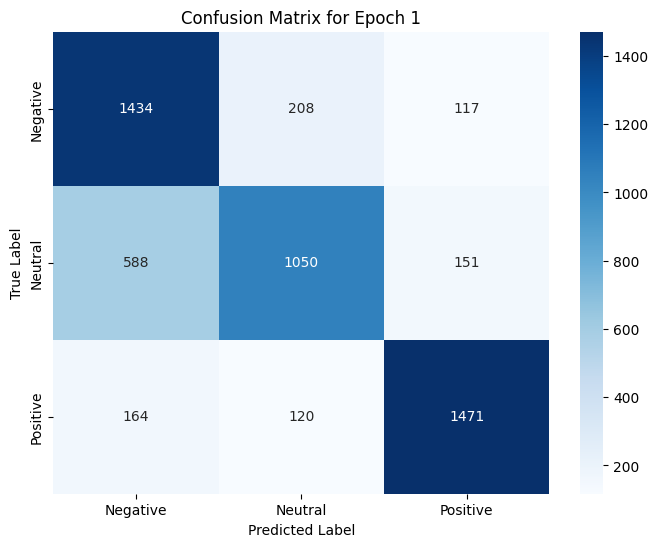

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}



===== Evaluating model from Epoch 2 =====
Tokenizer not found in /content/drive/MyDrive/finetuned_afriberta_mlm_epoch_2, loading original pretrained tokenizer...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at /content/d

Training model from Epoch 2...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.656200,0.606834,0.741875,0.744806,0.753594,0.741875
2,0.527800,0.569935,0.777363,0.777840,0.779636,0.777363
3,0.431600,0.604842,0.777363,0.777944,0.779013,0.777363


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation 

Evaluating model from Epoch 2...


Evaluation Results from Epoch 2: {'eval_loss': 0.5699349045753479, 'eval_accuracy': 0.7773627194620845, 'eval_f1': 0.7778404291988357, 'eval_precision': 0.7796362668294669, 'eval_recall': 0.7773627194620845, 'eval_runtime': 3.4132, 'eval_samples_per_second': 784.309, 'eval_steps_per_second': 98.149, 'epoch': 3.0}
Testing model from Epoch 2...
Test Results from Epoch 2: {'test_loss': 0.6146788001060486, 'test_accuracy': 0.7505185743918537, 'test_f1': 0.7484458361047152, 'test_precision': 0.760736118646133, 'test_recall': 0.7505185743918537, 'test_runtime': 6.1122, 'test_samples_per_second': 867.605, 'test_steps_per_second': 108.471}


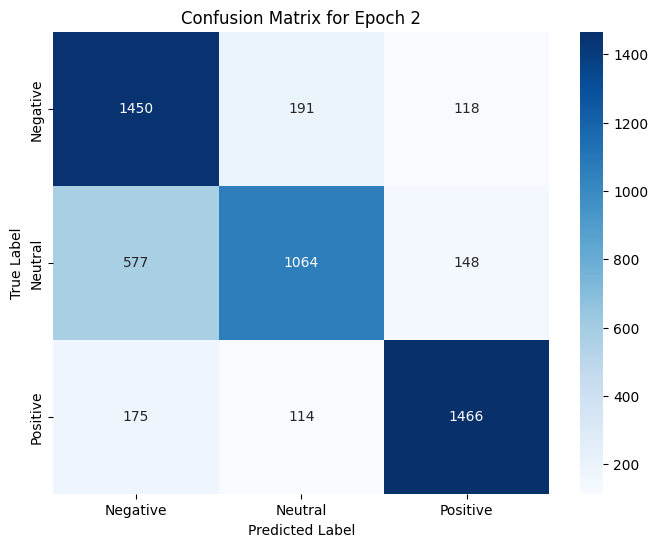

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}



===== Evaluating model from Epoch 3 =====
Tokenizer not found in /content/drive/MyDrive/finetuned_afriberta_mlm_epoch_3, loading original pretrained tokenizer...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at /content/d

Training model from Epoch 3...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.654700,0.607685,0.741875,0.744757,0.753474,0.741875
2,0.525900,0.571269,0.775495,0.775964,0.777720,0.775495
3,0.429800,0.607338,0.776242,0.776847,0.777904,0.776242


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation 

Evaluating model from Epoch 3...


Evaluation Results from Epoch 3: {'eval_loss': 0.5712690949440002, 'eval_accuracy': 0.7754949570414643, 'eval_f1': 0.7759638705209742, 'eval_precision': 0.7777202031403734, 'eval_recall': 0.7754949570414643, 'eval_runtime': 3.4269, 'eval_samples_per_second': 781.171, 'eval_steps_per_second': 97.756, 'epoch': 3.0}
Testing model from Epoch 3...
Test Results from Epoch 3: {'test_loss': 0.6149026155471802, 'test_accuracy': 0.7471242692815387, 'test_f1': 0.7446175653155261, 'test_precision': 0.7573661125233146, 'test_recall': 0.7471242692815387, 'test_runtime': 6.2594, 'test_samples_per_second': 847.212, 'test_steps_per_second': 105.921}


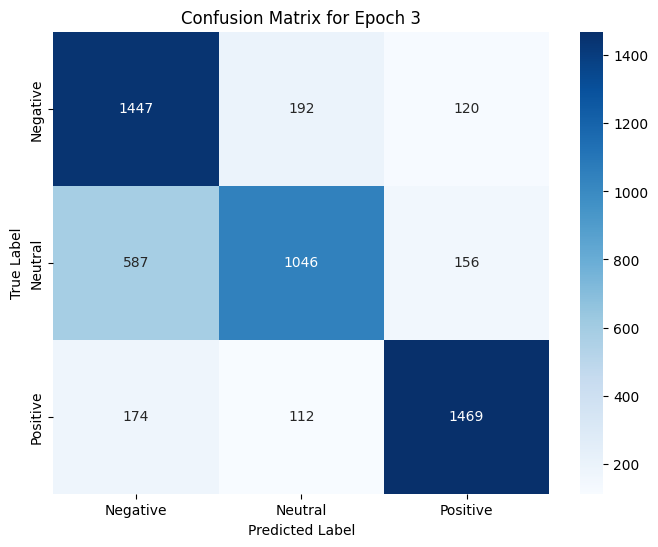

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}



===== Evaluating model from Epoch 4 =====
Tokenizer not found in /content/drive/MyDrive/finetuned_afriberta_mlm_epoch_4, loading original pretrained tokenizer...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at /content/d

Training model from Epoch 4...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.654000,0.607351,0.741502,0.744416,0.753297,0.741502
2,0.526200,0.571268,0.775495,0.775949,0.777892,0.775495
3,0.428400,0.607866,0.777363,0.777913,0.778910,0.777363


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation 

Evaluating model from Epoch 4...


Evaluation Results from Epoch 4: {'eval_loss': 0.5712676048278809, 'eval_accuracy': 0.7754949570414643, 'eval_f1': 0.7759491806744787, 'eval_precision': 0.7778919296260852, 'eval_recall': 0.7754949570414643, 'eval_runtime': 3.4087, 'eval_samples_per_second': 785.351, 'eval_steps_per_second': 98.279, 'epoch': 3.0}
Testing model from Epoch 4...
Test Results from Epoch 4: {'test_loss': 0.6169416904449463, 'test_accuracy': 0.7461814067508957, 'test_f1': 0.7437098767612836, 'test_precision': 0.7579655888270239, 'test_recall': 0.7461814067508957, 'test_runtime': 6.215, 'test_samples_per_second': 853.263, 'test_steps_per_second': 106.678}


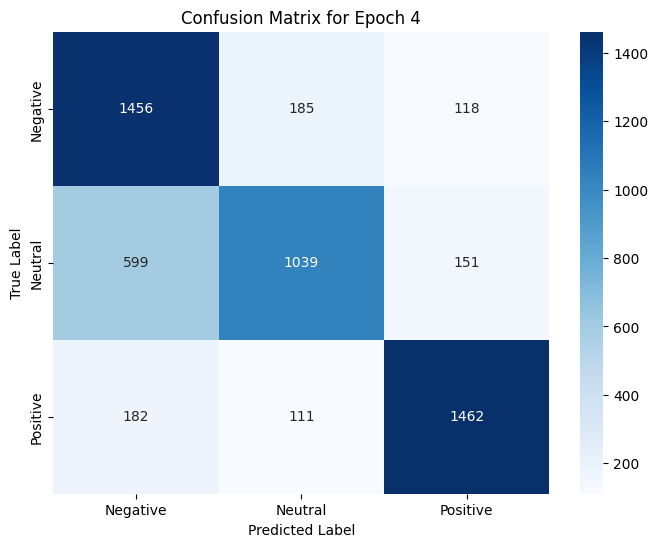

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}



===== Evaluating model from Epoch 5 =====
Tokenizer not found in /content/drive/MyDrive/finetuned_afriberta_mlm_epoch_5, loading original pretrained tokenizer...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at /content/d

Training model from Epoch 5...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.653900,0.607499,0.741128,0.744051,0.753028,0.741128
2,0.526300,0.571123,0.774748,0.775251,0.777019,0.774748
3,0.428300,0.607637,0.777363,0.777959,0.779024,0.777363


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation 

Evaluating model from Epoch 5...


Evaluation Results from Epoch 5: {'eval_loss': 0.5711230039596558, 'eval_accuracy': 0.7747478520732163, 'eval_f1': 0.7752514367710035, 'eval_precision': 0.7770189049976561, 'eval_recall': 0.7747478520732163, 'eval_runtime': 3.4336, 'eval_samples_per_second': 779.644, 'eval_steps_per_second': 97.565, 'epoch': 3.0}
Testing model from Epoch 5...
Test Results from Epoch 5: {'test_loss': 0.6156812310218811, 'test_accuracy': 0.7452385442202527, 'test_f1': 0.7427364403059191, 'test_precision': 0.7563617745045096, 'test_recall': 0.7452385442202527, 'test_runtime': 6.1332, 'test_samples_per_second': 864.633, 'test_steps_per_second': 108.1}


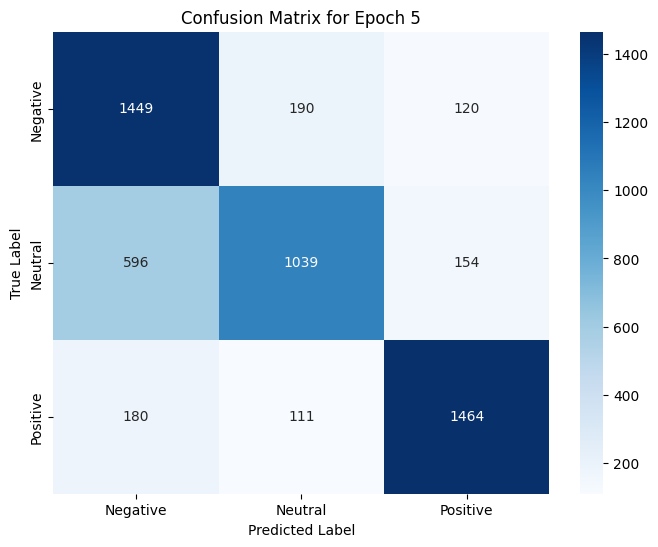

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512}


In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_small")

# Define label mapping for sentiment
label_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

# Load the TSV datasets
dataset = load_dataset('csv',
                       data_files={
                           'train': '/content/drive/MyDrive/finetuning data/train.tsv',
                           'validation': '/content/drive/MyDrive/finetuning data/dev.tsv',
                           'test': '/content/drive/MyDrive/finetuning data/test.tsv'
                       },
                       delimiter='\t')

# Map string labels to numerical labels
def map_labels(example):
    example['label'] = label_mapping[example['label']]
    return example

# Map labels in the dataset
dataset = dataset.map(map_labels)

# Define tokenizer preprocessing function
def preprocess_function(examples):
    return tokenizer(examples['tweet'], padding='max_length', truncation=True)

# Tokenize the dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)
train_dataset = tokenized_datasets['train']
eval_dataset = tokenized_datasets['validation']
test_dataset = tokenized_datasets['test']

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Iterate through saved models from each epoch
for epoch in range(1, 6):
    # Define model directory for each epoch
    model_dir = f"/content/drive/MyDrive/finetuned_afriberta_mlm_epoch_{epoch}"

    # Check if the model directory exists
    if not os.path.exists(model_dir):
        print(f"Model directory {model_dir} does not exist. Skipping...")
        continue

    print(f"\n===== Evaluating model from Epoch {epoch} =====")

    # Load the tokenizer and model for this epoch
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_dir)
    except:
        # If the tokenizer is not saved, load the original pretrained tokenizer
        print(f"Tokenizer not found in {model_dir}, loading original pretrained tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained("castorini/afriberta_small")

    model = AutoModelForSequenceClassification.from_pretrained(
        model_dir,
        num_labels=3  # Number of sentiment classes: Negative, Neutral, Positive
    )

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_epoch_{epoch}",
        eval_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        save_total_limit=2,
        load_best_model_at_end=True,
        save_strategy="epoch",
        report_to="tensorboard"
    )

    # Set up the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train the model
    print(f"Training model from Epoch {epoch}...")
    trainer.train()

    # Evaluate on validation set
    print(f"Evaluating model from Epoch {epoch}...")
    eval_results = trainer.evaluate()
    print(f"Evaluation Results from Epoch {epoch}: {eval_results}")

    # Predict on test set
    print(f"Testing model from Epoch {epoch}...")
    test_results = trainer.predict(test_dataset)
    print(f"Test Results from Epoch {epoch}: {test_results.metrics}")

    # Get true and predicted labels for confusion matrix
    y_true = test_results.label_ids
    y_pred = np.argmax(test_results.predictions, axis=1)

    # Define label names
    labels = ["Negative", "Neutral", "Positive"]

    # Compute and plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix for Epoch {epoch}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Save the model and tokenizer from this downstream task
    model.save_pretrained(f"./sentiment_finetuned_afriberta_mlm_epoch_{epoch}")
    tokenizer.save_pretrained(f"./sentiment_finetuned_afriberta_mlm_epoch_{epoch}")

# Optional: Start TensorBoard for all runs
# %load_ext tensorboard
# %tensorboard --logdir results/
